<a href="https://colab.research.google.com/github/dsjtx/Belajar-Flutter/blob/master/Submission_Time_Series_dengan_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d ahmedadam415/digital-currency-time-series

  0% 0.00/40.3k [00:00<?, ?B/s]
100% 40.3k/40.3k [00:00<00:00, 36.4MB/s]


In [ ]:
! unzip digital-currency-time-series.zip

Archive:  digital-currency-time-series.zip
  inflating: dc.csv                  


In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('dc.csv')
data.head()

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [ ]:
data_train, data_valid, train, valid = train_test_split(data, data, test_size=0.2, random_state=None, shuffle=False)
del train, valid

In [ ]:
data_train

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
29,2021-01-01,108475.181952,28923.63,111011.840000,29600.00,107353.587328,28624.57,110005.570176,29331.69,54182
535,2019-08-14,40854.457344,10893.36,40869.908992,10897.48,37234.346240,9928.10,37692.907648,10050.37,54451
695,2019-03-07,14483.444736,3861.84,14646.812160,3905.40,14403.036160,3840.40,14527.699456,3873.64,26455
557,2019-07-23,38790.687232,10343.08,38794.025088,10343.97,36836.428800,9822.00,36997.358464,9864.91,47624
836,2018-10-17,25363.055104,6762.76,25544.424448,6811.12,25037.707904,6676.01,25281.033856,6740.89,26641
...,...,...,...,...,...,...,...,...,...,...
106,2020-10-16,43148.839552,11505.13,43283.928960,11541.15,42004.480000,11200.00,42451.977728,11319.32,48797
270,2020-05-05,33273.248768,8871.92,34198.322432,9118.58,32853.504000,8760.00,33835.471232,9021.83,76480
860,2018-09-23,25214.126720,6723.05,25458.577792,6788.23,24984.227200,6661.75,25157.683200,6708.00,30286
435,2019-11-22,28607.263616,7627.79,29065.600000,7750.00,25465.216000,6790.00,27258.769792,7268.23,126603


In [ ]:
data_train['Unnamed: 0']

29     2021-01-01
535    2019-08-14
695    2019-03-07
557    2019-07-23
836    2018-10-17
          ...    
106    2020-10-16
270    2020-05-05
860    2018-09-23
435    2019-11-22
102    2020-10-20
Name: Unnamed: 0, Length: 800, dtype: object

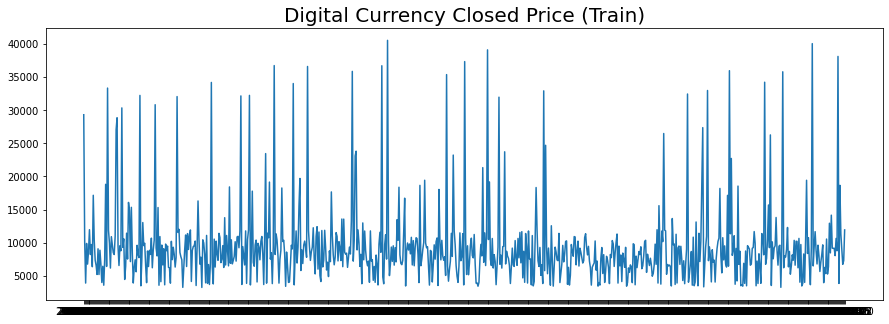

In [ ]:
dates_train  = data_train['Unnamed: 0'].values
close_usd_train = data_train['close_USD'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates_train, close_usd_train)
plt.title('Digital Currency Closed Price (Train)',
          fontsize=20);

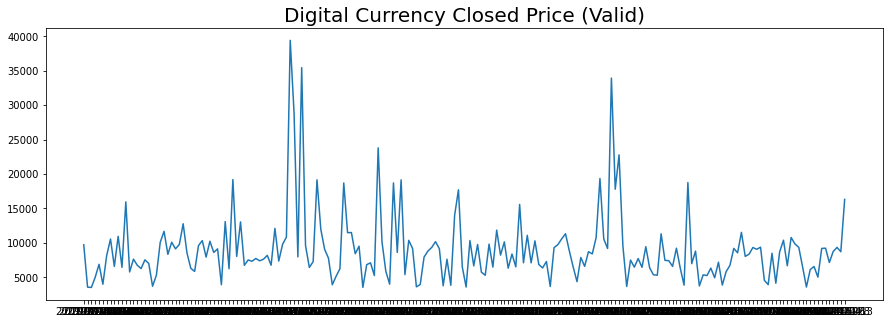

In [ ]:
dates_valid  = data_valid['Unnamed: 0'].values
close_usd_valid = data_valid['close_USD'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates_valid, close_usd_valid)
plt.title('Digital Currency Closed Price (Valid)',
          fontsize=20);

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(close_usd_train, window_size=60, batch_size=100, shuffle_buffer=1000)
valid_set = windowed_dataset(close_usd_valid, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(
              train_set, 
              validation_data=valid_set,
              epochs=100
              )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 7s 280ms/step - loss: 9260.0713 - mae: 9260.5713 - val_loss: 8762.8809 - val_mae: 8763.3809
Epoch 2/100
8/8 [==============================] - 1s 118ms/step - loss: 9260.0391 - mae: 9260.5391 - val_loss: 8762.8281 - val_mae: 8763.3281
Epoch 3/100
8/8 [==============================] - 1s 117ms/step - loss: 9259.9727 - mae: 9260.4727 - val_loss: 8762.7695 - val_mae: 8763.2695
Epoch 4/100
8/8 [==============================] - 1s 118ms/step - loss: 9259.9229 - mae: 9260.4229 - val_loss: 8762.7188 - val_mae: 8763.2188
Epoch 5/100
8/8 [==============================] - 1s 118ms/step - loss: 9259.8740 - mae: 9260.3740 - val_loss: 8762.6709 - val_mae: 8763.1719
Epoch 6/100
8/8 [==============================] - 1s 118ms/step - loss: 9259.8242 - mae: 9260.3242 - val_loss: 8762.6182 - val_mae: 8763.1182
Epoch 7/100
8/8 [==============================] - 1s 118ms/step - loss: 9259.7686 - mae: 9260.2686 - val_loss: 8762.5605 - val_mae: 8763.0605
Epoch 8/100

In [ ]:
history.history.values()

dict_values([[9260.0712890625, 9260.0390625, 9259.97265625, 9259.9228515625, 9259.8740234375, 9259.82421875, 9259.7685546875, 9259.7119140625, 9259.654296875, 9259.5986328125, 9259.5390625, 9259.4765625, 9259.408203125, 9259.333984375, 9259.2529296875, 9259.166015625, 9259.0751953125, 9258.9765625, 9258.8720703125, 9258.7587890625, 9258.63671875, 9258.5029296875, 9258.3544921875, 9258.193359375, 9258.0087890625, 9257.802734375, 9257.572265625, 9257.3193359375, 9257.0380859375, 9256.7255859375, 9256.373046875, 9255.9765625, 9255.5263671875, 9255.01171875, 9254.419921875, 9253.7373046875, 9252.947265625, 9252.0244140625, 9250.943359375, 9249.6640625, 9248.140625, 9246.30859375, 9244.07421875, 9241.314453125, 9237.857421875, 9233.453125, 9227.7392578125, 9220.1630859375, 9209.87109375, 9195.482421875, 9174.6806640625, 9143.400390625, 9094.1015625, 9012.0478515625, 8866.525390625, 8587.9638671875, 8000.3115234375, 6589.83642578125, 4035.299560546875, 3680.53857421875, 3320.853759765625, 33

In [ ]:
value = [x for l in list(history.history.values()) for x in l]
max_value = max(value)
min_value = min(value)

[9260.0712890625,
 9260.0390625,
 9259.97265625,
 9259.9228515625,
 9259.8740234375,
 9259.82421875,
 9259.7685546875,
 9259.7119140625,
 9259.654296875,
 9259.5986328125,
 9259.5390625,
 9259.4765625,
 9259.408203125,
 9259.333984375,
 9259.2529296875,
 9259.166015625,
 9259.0751953125,
 9258.9765625,
 9258.8720703125,
 9258.7587890625,
 9258.63671875,
 9258.5029296875,
 9258.3544921875,
 9258.193359375,
 9258.0087890625,
 9257.802734375,
 9257.572265625,
 9257.3193359375,
 9257.0380859375,
 9256.7255859375,
 9256.373046875,
 9255.9765625,
 9255.5263671875,
 9255.01171875,
 9254.419921875,
 9253.7373046875,
 9252.947265625,
 9252.0244140625,
 9250.943359375,
 9249.6640625,
 9248.140625,
 9246.30859375,
 9244.07421875,
 9241.314453125,
 9237.857421875,
 9233.453125,
 9227.7392578125,
 9220.1630859375,
 9209.87109375,
 9195.482421875,
 9174.6806640625,
 9143.400390625,
 9094.1015625,
 9012.0478515625,
 8866.525390625,
 8587.9638671875,
 8000.3115234375,
 6589.83642578125,
 4035.29956054